In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow.keras.metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
import warnings
import time
from utils import my_precision,my_recall,my_f1,my_roc_auc,get_specificity,get_balanced_acc,plotConfusionMatrix,plotCurves,progressBar,plotROCCurve

warnings.filterwarnings('always')

In [16]:
import pandas as pd

# Load the updated CSV file
status_data = pd.read_csv("../COVID_19 Project/filtered_status.csv")

# Assuming 'status' column contains 'healthy' and 'COVID-19'
status_data['status'] = status_data['status'].apply(lambda x: 1 if x == 'COVID-19' else 0)



# Save the updated CSV with binary status
status_data.to_csv("status_updated.csv", index=False)

print("Status updated and file saved successfully.")

Status updated and file saved successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset count:  876  Shape:  (876, 308, 310, 3)
Train set size :  876
Test set size :  219
Sample image:
Label:  0


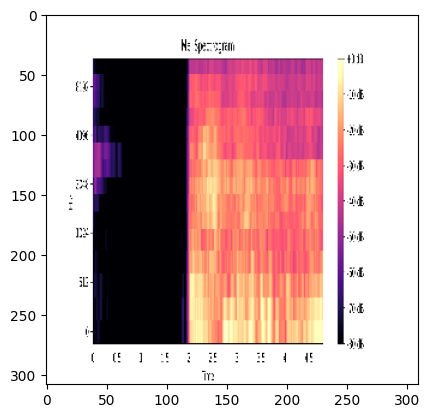

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Path to your images
path = "../Covid_19 Project/mel1/"  # Change this to the correct path of your images

# Image array size
imgArraySize = (310, 308)

# Load the CSV file containing 'uuid' and 'status'
labels = pd.read_csv('status_updated.csv')
labels.columns = ['uuid', 'status']  # Ensure your CSV has two columns: 'uuid' and 'status'

# Sort the labels DataFrame by 'uuid' to match the image order
labels['uuid'] = labels['uuid'].astype(str)  # Ensure UUIDs are strings
labels = labels.sort_values(by='uuid').reset_index(drop=True)

# List all image files in the directory (sorted lexicographically by UUID)
image_filenames = sorted(os.listdir(path))  # Sort by filename (lexicographically)

# Initialize list for images and their corresponding labels
images = []
covid_status = []

# Loop through image filenames and match with the 'uuid' column in the labels DataFrame
for filename in image_filenames:
    # Get the UUID from the image filename (assuming it's the part before .png)
    uuid = os.path.splitext(filename)[0]
    
    # Find the corresponding status from the CSV
    status = labels[labels['uuid'] == uuid]['status'].values
    
    if len(status) > 0:  # Make sure we have a match
        status = status[0]
        
        # Read and preprocess the image
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, imgArraySize)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.asarray(img, dtype=np.float32)
        img = img / 225.0
        
        if img is not None:
            images.append(img)
            covid_status.append(status)

# Convert lists to numpy arrays
images = np.asarray(images)
covid_status = np.asarray(covid_status)

# Check the shape of the dataset
rows = imgArraySize[1]
cols = imgArraySize[0]

# Reshape images based on Keras backend image data format
if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 3, rows, cols)
    input_shape = (3, rows, cols)
else:
    images = images.reshape(images.shape[0], rows, cols, 3)
    input_shape = (rows, cols, 3)

# Shuffle and split the data into training and test sets
np.random.seed(75)
images, covid_status = shuffle(images, covid_status, random_state=75)
(trainX, testX, trainY, testY) = train_test_split(images, covid_status, test_size=0.2, shuffle=True)

# Clean up to free memory
del images, covid_status

# Print dataset details
print("Dataset count: ", len(trainX), " Shape: ", trainX.shape)
print("Train set size : ", len(trainX))
print("Test set size : ", len(testX))

# Display sample image and label
print("Sample image:")
plt.imshow(trainX[0])
print("Label: ", trainY[0])


path = "../Covid_19 Project/mel1/"
names = sorted(os.listdir(path), key=lambda x: int(os.path.splitext(x)[0]))
imgArraySize = (310,308)

# Loading Images

images = []
for filename in progressBar(names, prefix = 'Reading:', suffix = '', length = 50):
    img = cv2.imread(os.path.join(path,filename))
    img = cv2.resize(img,imgArraySize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img,dtype=np.float32)
    img = img/225.0
    if img is not None:
        images.append(img)

images = np.squeeze(images)

# Loading Labels
labels = pd.read_csv('status_updated.csv')
labels.columns = ['status']
covid_status = labels["status"]
covid_status = np.asarray(covid_status)

rows = imgArraySize[1]
cols = imgArraySize[0]

if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0],3,rows,cols)
    input_shape = (3, rows, cols)
else:
    images = images.reshape(images.shape[0],rows,cols,3)
    input_shape = (rows, cols,3)
    
print("Dataset count: ",len(images)," Shape: ",images.shape)
print("Labels count: ",len(covid_status)," Shape: ",covid_status.shape)
print("Sample:")
plt.imshow(images[0])
print("Label: ",covid_status[0])

np.random.seed(75)

images,covid_status = shuffle(images,covid_status, random_state=75)
(trainX,testX,trainY,testY) = train_test_split(images,covid_status,test_size=0.2,shuffle=True)

del images,covid_status

print("Train set size : ",len(trainX))
print("Test set size : ",len(testX))

In [19]:
## Evaluation metrics

scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(my_precision),
           'recall':make_scorer(my_recall),
           'roc_auc':make_scorer(my_roc_auc),
           'f1':make_scorer(my_f1),
           'balanced_accuracy': 'balanced_accuracy'}


In [20]:
## Start 10-fold cross-validation

num_folds = 5
fold_no = 1

acc_per_fold = []
recall_per_fold = []
precision_per_fold = []
roc_auc_per_fold = []
f1_per_fold = []
balanced_acc = []
specificity_per_fold = []
loss_per_fold = []
histories = []

METRICS = [
    tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name='precision'),
    tensorflow.keras.metrics.Recall(name='recall'),
    tensorflow.keras.metrics.AUC(name='AUC')
]

kfold = KFold(n_splits=num_folds, shuffle=True,random_state=75)

for train,test in kfold.split(trainX,trainY):
    epochs = 5
    batch_size = 256
    learning_rate = 0.001
    optimizer = tensorflow.keras.optimizers.Adamax(learning_rate = learning_rate)
    filepath="model_best_weights_"+str(fold_no)+".hdf5"    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ###### Model architecture
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs = Input(shape=input_shape,name='input')
    x = Conv2D(16,(2,2),strides=(1,1),padding='valid',kernel_initializer='normal')(inputs)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(16,(2,2), strides=(1, 1), padding="valid",kernel_initializer='normal')(x)
    x = AveragePooling2D((2,2), strides=(1,1))(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1,name='output_layer')(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=METRICS)
    start = time.time()
    history = model.fit(trainX[train], trainY[train], batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(trainX[test],trainY[test]),callbacks=[checkpoint])
    end = time.time()
    print("Training time : ",(end-start))
    histories.append(history)
    scores = model.evaluate(trainX[test], trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict >= 0.5, 1,0)
    real_stat = trainY[test]
    acc_per_fold.append(scores[1])
    recall_per_fold.append(my_recall(real_stat, covPredict))
    precision_per_fold.append(my_precision(real_stat, covPredict))
    roc_auc_per_fold.append(my_roc_auc(real_stat, covPredict))
    f1_per_fold.append(my_f1(real_stat, covPredict))
    balanced_acc.append(get_balanced_acc(real_stat, covPredict))
    specificity_per_fold.append((2*get_balanced_acc(trainY[test],covPredict))-my_recall(trainY[test],covPredict))
    loss_per_fold.append(scores[0])
    model = load_model('model_best_weights_'+str(fold_no)+'.hdf5')
    score = model.evaluate(trainX[test],trainY[test], verbose=0)
    covPredict = model.predict(trainX[test])
    covPredict = np.where(covPredict >= 0.5, 1,0)
    print("Validation results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(trainY[test],covPredict))
    print("Recall : ",my_recall(trainY[test],covPredict))
    print("F1 : ",my_f1(trainY[test],covPredict))
    print("ROC AUC : ",my_roc_auc(trainY[test],covPredict))
    print("Specificity : ",(2*get_balanced_acc(trainY[test],covPredict))-my_recall(trainY[test],covPredict))
    score = model.evaluate(testX,testY,verbose=0)
    covPredict = model.predict(testX)
    covPredict = np.where(covPredict >= 0.5, 1,0)
    print("Test results for the fold "+str(fold_no)+":")
    print("Accuracy : ",score[1])
    print("Precision : ",my_precision(testY,covPredict))
    print("Recall : ",my_recall(testY,covPredict))
    print("F1 : ",my_f1(testY,covPredict))
    print("ROC AUC : ",my_roc_auc(testY,covPredict))
    print("Specificity : ",(2*get_balanced_acc(testY,covPredict))-my_recall(testY,covPredict))
    fold_no = fold_no + 1

print("Accuracy per fold : ",acc_per_fold)
print("Precision per fold : ",precision_per_fold)
print("Recall per fold : ",recall_per_fold)
print("ROC AUC per fold : ",roc_auc_per_fold)
print("F1 per fold : ",f1_per_fold)
print("Specificity per fold : ",specificity_per_fold)

print("Mean Accuracy : ",np.mean(acc_per_fold))
print("std Accuracy : ",np.std(acc_per_fold))
print("Mean Precision : ",np.mean(precision_per_fold))
print("std Precision : ",np.std(precision_per_fold))
print("Mean Recall : ",np.mean(recall_per_fold))
print("std Recall : ",np.std(recall_per_fold))
print("Mean ROC AUC : ",np.mean(roc_auc_per_fold))
print("std ROC AUC : ",np.std(roc_auc_per_fold))
print("Mean F1 : ",np.mean(f1_per_fold))
print("std F1 : ",np.std(f1_per_fold))
print("Mean Specificity : ",np.mean(get_specificity(balanced_acc,recall_per_fold)))
print("std Specificity : ",np.std(get_specificity(balanced_acc,recall_per_fold)))

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 14.5920 - accuracy: 0.5929 - precision: 0.2989 - recall: 0.1040 - AUC: 0.5129 
Epoch 1: val_accuracy improved from -inf to 0.38636, saving model to model_best_weights_1.hdf5
3/3 [==============================] - 76s 19s/step - loss: 14.5920 - accuracy: 0.5929 - precision: 0.2989 - recall: 0.1040 - AUC: 0.5129 - val_loss: 5.9037 - val_accuracy: 0.3864 - val_precision: 0.3864 - val_recall: 1.0000 - val_AUC: 0.5000
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 6.0519 - accuracy: 0.4586 - precision: 0.3475 - recall: 0.5880 - AUC: 0.5039 
Epoch 2: val_accuracy improved from 0.38636 to 0.61364, saving model to model_best_weights_1.hdf5
3/3 [==============================] - 67s 19s/step - loss: 6.0519 - accuracy: 0.4586 - precision: 0.3475 - recall: 0.5880 - AUC: 0.5039 - val_loss: 0.7102 - val_accuracy: 0.6136 -

7/7 [==============================] - 2s 276ms/step


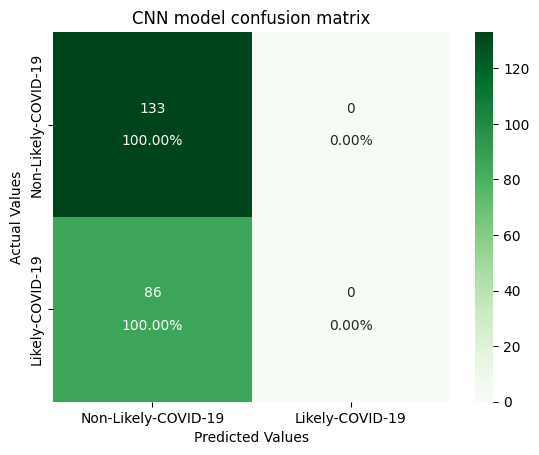

TypeError: 'History' object is not subscriptable

<Figure size 1400x800 with 0 Axes>

In [21]:
### Use the index of the best obtained model according to the test results

best_model = 3

model = load_model('model_best_weights_'+str(best_model)+'.hdf5')
score = model.evaluate(testX,testY, verbose=0)
covPredict = model.predict(testX)
covPredict = np.where(covPredict >= 0.5, 1,0)

## Plot confusion matrix
    
plotConfusionMatrix(testY,covPredict)

## Plot accuracy curves
plotCurves('CNN train and validation accuracy curves','Accuracy','Epoch','accuracy',histories)

## Plot loss curves
plotCurves('CNN train and validation loss curves','Loss','Epoch','loss',histories)

## Plot Sensitivity curves
plotCurves('CNN train and validation sensitivity curves','Sensitivity','Epoch','recall',histories)

## Plot Precision curves
plotCurves('CNN train and validation precision curves','Precision','Epoch','precision',histories)

## Plot ROC curve

probabilities = model.predict(testX).ravel()
fpr, tpr, thresholds = roc_curve(testY, probabilities, pos_label=1)
auc = auc(fpr, tpr)
plotROCCurve(fpr,tpr,auc,'darkred','CNN ROC AUC ','CNN baseline ROC AUC')